<a href="https://colab.research.google.com/github/sarikasea/Machine-Learning/blob/main/Credit_Card_Fraud_Detection_with_Decision_Trees_and_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction


Imagine that you work for a financial institution and part of your job is to build a model that predicts if a credit card transaction is fraudulent or not. You can model the problem as a binary classification problem. A transaction belongs to the positive class (1) if it is a fraud, otherwise it belongs to the negative class (0).

You have access to transactions that occured over a certain period of time. The majority of the transactions are normally legitimate and only a small fraction are non-legitimate. Thus, typically you have access to a dataset that is highly unbalanced. This is also the case of the current dataset: only 492 transactions out of 284,807 are fraudulent (the positive class - the frauds - accounts for 0.172% of all transactions).

This is a Kaggle dataset. You can find this "Credit Card Fraud Detection" dataset from the following link: Credit Card Fraud Detection.

To train the model, you can use part of the input dataset, while the remaining data can be utilized to assess the quality of the trained model. First, let's import the necessary libraries and download the dataset.

## Import Libraries and Data

In [1]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib

In [2]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')

In [3]:
# download the dataset
url= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/creditcard.csv"

# read the input data
raw_data=pd.read_csv(url)
raw_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Dataset Analysis

Each row in the dataset represents a credit card transaction. As shown above, each row has 31 variables. One variable (the last variable in the table above) is called Class and represents the target variable. Your objective will be to train a model that uses the other variables to predict the value of the Class variable. Let's first retrieve basic statistics about the target variable.

Note: For confidentiality reasons, the original names of most features are anonymized V1, V2 .. V28. The values of these features are the result of a PCA transformation and are numerical. The feature 'Class' is the target variable and it takes two values: 1 in case of fraud and 0 otherwise. For more information about the dataset please visit this webpage: https://www.kaggle.com/mlg-ulb/creditcardfraud.

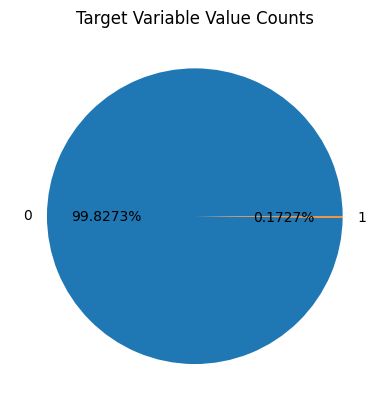

In [6]:
# get the set of distinct classes
labels = raw_data.Class.unique()

# get the count of each class
sizes = raw_data.Class.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.4f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

As shown above, the Class variable has two values: 0 (the credit card transaction is legitimate) and 1 (the credit card transaction is fraudulent). Thus, you need to model a binary classification problem. Moreover, the dataset is highly unbalanced, the target variable classes are not represented equally. This case requires special attention when training or when evaluating the quality of a model. One way of handing this case at train time is to bias the model to pay more attention to the samples in the minority class. The models under the current study will be configured to take into account the class weights of the samples at train/fit time.

The sentence "One way of handing this case at train time is to bias the model to pay more attention to the samples in the minority class. The models under the current study will be configured to take into account the class weights of the samples at train/fit time." refers to a technique used when training machine learning models on imbalanced datasets.

In an imbalanced dataset, like the credit card fraud data you have, one class (in this case, fraudulent transactions) has significantly fewer samples than the other (legitimate transactions). If you train a standard model on this data, it might become very good at predicting the majority class but poor at predicting the minority class because it doesn't see enough examples of the minority class during training.

"Biasing the model to pay more attention to the samples in the minority class" means giving more importance to the minority class during the training process. This is often done by using "class weights."

"The models under the current study will be configured to take into account the class weights of the samples at train/fit time" means that when training the models for this fraud detection task, a parameter called class_weight will be set. This parameter tells the model to give a higher weight to the samples from the minority class (fraudulent transactions) and a lower weight to the samples from the majority class (legitimate transactions). This helps the model learn to identify fraudulent transactions more effectively, even though they are rare.

It is also prudent to understand which features affect the model in what way. We can visualize the effect of the different features on the model using the code below.


<Axes: >

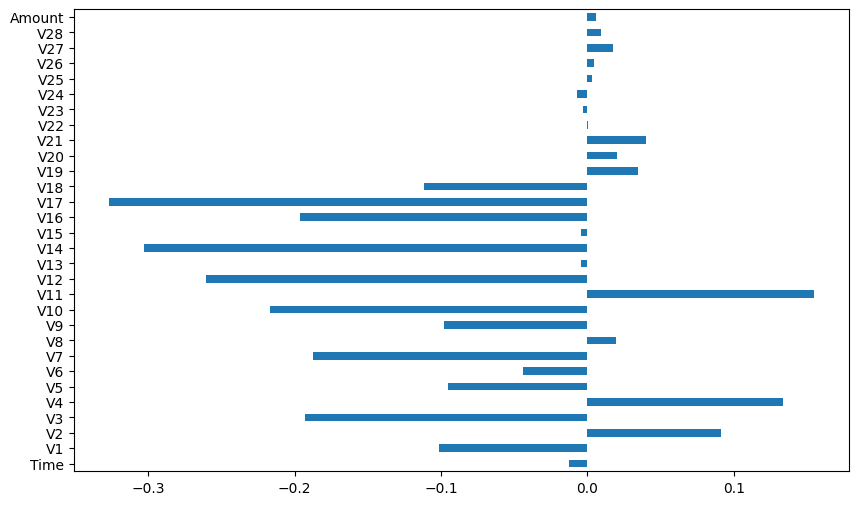

In [7]:
correlation_values = raw_data.corr()['Class'].drop('Class')
correlation_values.plot(kind='barh', figsize=(10, 6))

This clearly shows that some features affect the output Class more than the others. For efficient modeling, we may use only the most correlated features.

## Dataset Preprocessing

You will now prepare the data for training. You will apply standard scaling to the input features and normalize them using
 norm for the training models to converge quickly. As seen in the data snapshot, there is a parameter called Time which we will not be considering for modeling. Hence, features 2 to 30 will be used as input features and feature 31, i.e. Class will be used as the target variable.

In [8]:
raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(raw_data.iloc[:, 1:30])
data_matrix = raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

## Dataset Train/Test Split

Now that the dataset is ready for building the classification models, you need to first divide the pre-processed dataset into a subset to be used for training the model (the train set) and a subset to be used for evaluating the quality of the model (the test set).

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Build a Decision Tree Classifier with Sci-kit learn

Compute the sample weights to be used as input to the train routine so that it takes into account the class imbalance present in this dataset.

In [10]:
w_train = compute_sample_weight('balanced', y_train)

Using these sample weights, we may train the Decision Tree classifier. We also make note of the time it takes for training this model to compare it against SVM, later in the lab.

In [11]:
# for reproducible output across multiple function calls, set random_state to a given integer value
dt = DecisionTreeClassifier(max_depth=4, random_state=35)

dt.fit(X_train, y_train, sample_weight=w_train)

DecisionTreeClassifier(max_depth=4, random_state=35)

## Build a Support Vector Machine model with Scikit-Learn

Unlike Decision Trees, we do not need to initiate a separate sample_weight for SVMs. We can simply pass a parameter in the scikit-learn function.

In [12]:
# for reproducible output across multiple function calls, set random_state to a given integer value
svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

svm.fit(X_train, y_train)

LinearSVC(class_weight='balanced', fit_intercept=False, loss='hinge',
          random_state=31)

## Evaluate the Decision Tree Classifier Models

Run the following cell to compute the probabilities of the test samples belonging to the class of fraudulent transactions.


In [13]:
y_pred_dt = dt.predict_proba(X_test)[:,1]

Using these probabilities, we can evaluate the Area Under the Receiver Operating Characteristic Curve (ROC-AUC) score as a metric of model performance. The AUC-ROC score evaluates your model's ability to distinguish positive and negative classes considering all possible probability thresholds. The higher its value, the better the model is considered for separating the two classes of values.

In [14]:
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print('Decision Tree ROC-AUC score : {0:.3f}'.format(roc_auc_dt))

Decision Tree ROC-AUC score : 0.939


## Evaluate the Support Vector Machine

Run the following cell to compute the probabilities of the test samples belonging to the class of fraudulent transactions.


In [15]:
y_pred_svm = svm.decision_function(X_test)

You may now evaluate the accuracy of SVM on the test set in terms of the ROC-AUC score.


In [16]:
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
print("SVM ROC-AUC score: {0:.3f}".format(roc_auc_svm))

SVM ROC-AUC score: 0.986


## Practice Exercises

Q1. Currently, we have used all 30 features of the dataset for training the models. Use the corr() function to find the top 6 features of the dataset to train the models on.

In [17]:
correlation_values = abs(raw_data.corr()['Class']).drop('Class')
correlation_values = correlation_values.sort_values(ascending=False)[:6]
correlation_values

,Class
V17,0.326481
V14,0.302544
V12,0.260593
V10,0.216883
V16,0.196539
V3,0.192961


Q2. Using only these 6 features, modify the input variable for training.


In [18]:
## 1. Data Preprocessing

raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(raw_data.iloc[:, 1:30])
data_matrix = raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:,[3,10,12,14,16,17]]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

## 2. train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 3. build a decision tree classifier with scikit learn

w_train = compute_sample_weight('balanced', y_train)
dt = DecisionTreeClassifier(max_depth=4, random_state=35)

dt.fit(X_train, y_train, sample_weight=w_train)

## 4. build an SVM

svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

svm.fit(X_train, y_train)

## 5. Evaluate Decision Tree

y_pred_dt = dt.predict_proba(X_test)[:,1]
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print('Decision Tree ROC-AUC score : {0:.3f}'.format(roc_auc_dt))


## 6. Evaluate SVM

y_pred_svm = svm.decision_function(X_test)
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
print("SVM ROC-AUC score: {0:.3f}".format(roc_auc_svm))


Decision Tree ROC-AUC score : 0.952
SVM ROC-AUC score: 0.937


Q3. Execute the Decision Tree model for this modified input variable. How does the value of ROC-AUC metric change?


observed an increase in the ROC-AUC for Decision Tree and a decrease in ROC-AUC for SVM

Q4. Execute the SVM model for this modified input variable. How does the value of ROC-AUC metric change?


Q5. What are the inferences you can draw about Decision Trees and SVMs with what you have learnt in this lab?


With a larger set of features, SVM performed relatively better in comparison to the Decision Trees.
Decision Trees benefited from feature selection and performed better.
SVMs may require higher feature dimensionality to create an efficient decision hyperplane.

Decision Trees: Decision trees are non-linear models that can capture complex interactions between features. When you reduce the number of features to the most highly correlated ones, you might be providing the Decision Tree with a clearer signal, reducing noise from less relevant features. This can lead to a better ability to separate the classes and thus a higher ROC-AUC. Decision trees are also less sensitive to the scale of features, so removing less important features might not hurt their performance as much as it could for other models.
SVMs: Support Vector Machines, particularly linear SVMs as used here, find a linear decision boundary that best separates the classes. While more correlated features can be beneficial, SVMs are also sensitive to the interplay of features and can be affected by multicollinearity (when features are highly correlated with each other). It's possible that even among the top 6 features, there are relationships that a linear model struggles with, or that some combination of the original 30 features, even those with lower individual correlations, contributed to a better linear separation in the higher-dimensional space. Removing these features might have negatively impacted the SVM's ability to find the optimal linear boundary, leading to a lower ROC-AUC.
It's important to remember that the "best" set of features can be model-dependent. What works well for one type of model might not be optimal for another. The observed results suggest that for this specific dataset and the chosen parameters, the Decision Tree benefited from the feature reduction, while the SVM's performance was slightly hindered.

